In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
NUM_EPOCHS = 10

In [4]:
from scripts.data_loader import get_dataloaders_sportballs

train_loader, test_loader = get_dataloaders_sportballs(BATCH_SIZE)

In [5]:
print('\n Training Set')
for images, labels in train_loader:
    print('Image batch size dimension: ', images.size())
    print('Image label size dimension: ', labels.size())
    print(labels[:10])
    break

print('\n Testing Set')
for images, labels in test_loader:
    print('Image batch size dimension: ', images.size())
    print('Image label size dimension: ', labels.size())
    print(labels[:10])
    break


 Training Set
Image batch size dimension:  torch.Size([32, 3, 32, 32])
Image label size dimension:  torch.Size([32])
tensor([2, 2, 3, 1, 2, 1, 2, 2, 2, 0])

 Testing Set
Image batch size dimension:  torch.Size([32, 3, 32, 32])
Image label size dimension:  torch.Size([32])
tensor([1, 0, 3, 1, 3, 2, 0, 2, 1, 3])


In [6]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :32 , :32]

In [7]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # [I - K + 2P / S  + 1]
            nn.Conv2d(3, 32 , stride=(1,1), kernel_size=(3,3), padding=1), #[32,32,32]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64 , stride=(2,2), kernel_size=(3,3), padding=1), #[64,16,16]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.25),

            nn.Conv2d(64,64, stride=(2,2), kernel_size=(3,3), padding=1), #[64,8,8]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.25), 

            nn.Conv2d(64,64, stride=(1,1), kernel_size=(3,3), padding=1), #[64,8,8]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.25),

            nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(4096,100)
        self.z_log_var = torch.nn.Linear(4096,100)


        self.decoder = nn.Sequential(
            nn.Linear(100,4096),
            Reshape(-1,64,8,8),
            # [(I - 1) * S - 2*P + K + OP]
            nn.ConvTranspose2d(64,64,stride=(1,1), kernel_size=(3,3),padding=1), #[64,8,8]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.25),

            nn.ConvTranspose2d(64,64,stride=(2,2), kernel_size=(3,3),padding=1), #[64,15,15]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.25),

            nn.ConvTranspose2d(64,32,stride=(2,2),kernel_size=(3,3),padding=0), #[32,31,31]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.25),

            nn.ConvTranspose2d(32,3,stride=(1,1),kernel_size=(3,3),padding=0), #[3,33,33]
            Trim(), #[3,33,33] -> [3,32,32]
            nn.Sigmoid()
        )

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1))
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
    

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [8]:
model = VariationalAutoEncoder()
model.to(DEVICE)

optimizer =  torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [8]:
from scripts.train import train_vae

log_dict = train_vae(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_loader,
                        logging_interval=250)

Epoch: 001/010 | Batch 0000/1875 | Loss: 1019.3741
Epoch: 001/010 | Batch 0250/1875 | Loss: 153.7933
Epoch: 001/010 | Batch 0500/1875 | Loss: 84.4747
Epoch: 001/010 | Batch 0750/1875 | Loss: 65.3105
Epoch: 001/010 | Batch 1000/1875 | Loss: 49.0835
Epoch: 001/010 | Batch 1250/1875 | Loss: 52.7792
Epoch: 001/010 | Batch 1500/1875 | Loss: 49.7511
Epoch: 001/010 | Batch 1750/1875 | Loss: 55.4587
***Epoch: 001/010 | Loss: 35.901
Epoch: 002/010 | Batch 0000/1875 | Loss: 44.3968
Epoch: 002/010 | Batch 0250/1875 | Loss: 39.0253
Epoch: 002/010 | Batch 0500/1875 | Loss: 42.1047
Epoch: 002/010 | Batch 0750/1875 | Loss: 42.4854
Epoch: 002/010 | Batch 1000/1875 | Loss: 44.1233
Epoch: 002/010 | Batch 1250/1875 | Loss: 36.4914
Epoch: 002/010 | Batch 1500/1875 | Loss: 34.8427
Epoch: 002/010 | Batch 1750/1875 | Loss: 36.3255
***Epoch: 002/010 | Loss: 25.612
Epoch: 003/010 | Batch 0000/1875 | Loss: 35.7836
Epoch: 003/010 | Batch 0250/1875 | Loss: 36.4731
Epoch: 003/010 | Batch 0500/1875 | Loss: 35.1426


In [9]:
checkpoint = torch.load('models/v_autoencoder_checkpoint.pkl', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
log_dict = checkpoint['log_dict']
model.eval()

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.01)
    (15): D

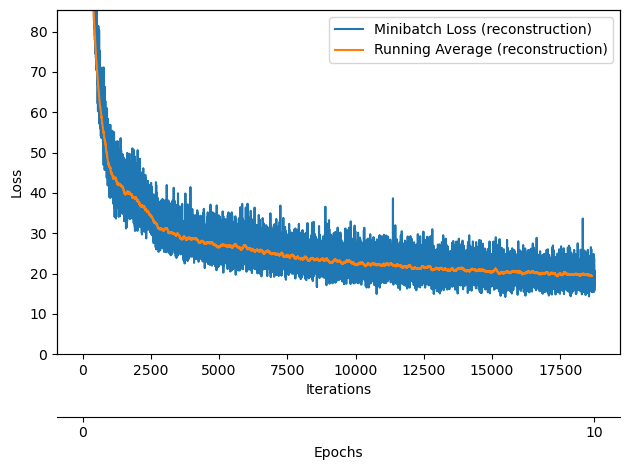

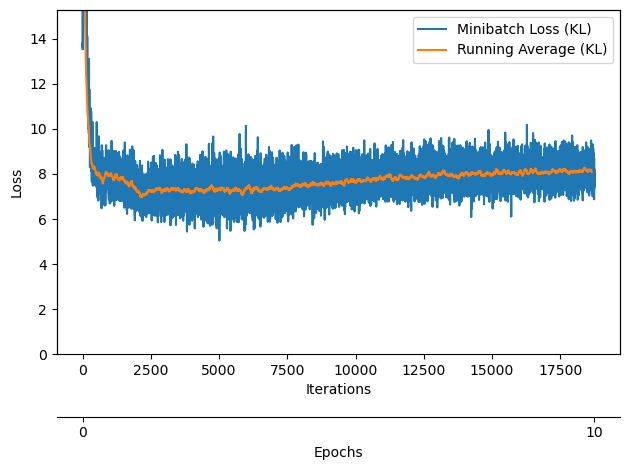

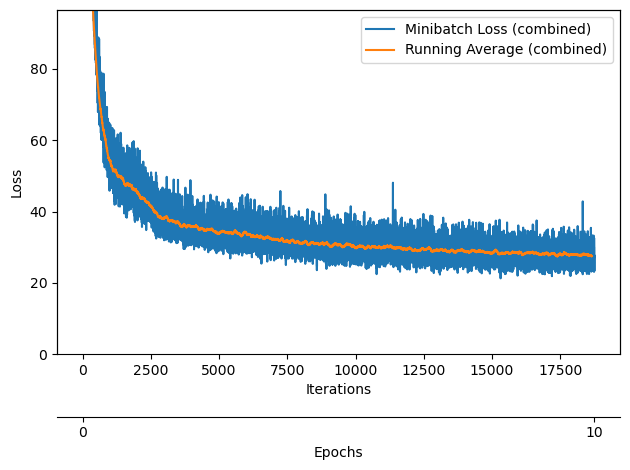

In [10]:
from scripts.plotting import plot_training_loss

plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

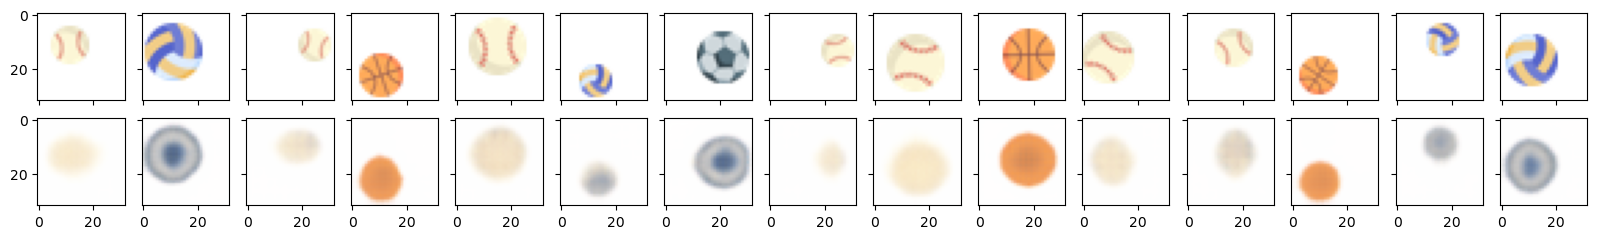

In [13]:
from scripts.plotting import plot_generated_images

plot_generated_images(data_loader=train_loader, model=model, device=DEVICE, modeltype='VAE')   

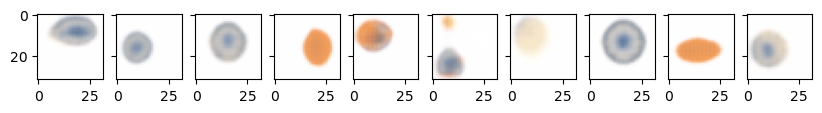

In [17]:
from scripts.plotting import plot_images_sampled_from_vae

plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=100)
plt.show()